# Analysis - Residential Area

Looking into the results of [geodata fusion](https://europa.dsa.missouri.edu/user/psmd39/notebooks/dsa_masters/DSA_Capstone/Geodata%20Fusion.ipynb) work to quantify the impacts of sex offender residence restrictions.

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# pip install GeoAlchemy2

In [4]:
# a few more imports specfic to the database process
# import geoalchemy2 # this is only needed if we're going to load data back into PostGIS
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Establish database connection

In [5]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [6]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


In [7]:
# establish cursor and read the existing tables
cursor = conn.cursor()

cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables = [i[0] for i in cursor.fetchall()] # A list() of tables.
tables.sort()
tables


['country_borders',
 'gadm_admin_borders',
 'geonames_feature',
 'msorfailedgeocoding',
 'spatial_ref_sys',
 'stlchildcare',
 'stlnonrestrictedresidential',
 'stlpubschools',
 'stlpvtschools',
 'stlresparcels',
 'stlrestrictedflat',
 'stlsexoffenders',
 'stlzoning']

#### Pull residental zoning data from PostGIS database

In [8]:
# create sql statement and pull from db into a geopandas dataframe
# we only need residential data here, so specify that during the SELECT
sql = "SELECT layer, description, res, geometry as geom FROM stlzoning WHERE res = True;"
gdf_zoning = gpd.read_postgis(sql, conn)
# gpd_childcare = gpd_childcare.drop(columns='geometry') # drop the duplicate geometry column
gdf_zoning.head()

,layer,description,res,geom
0,K,Unrestricted,True,"POLYGON ((590981.742 1019859.915, 590977.743 1..."
1,K,Unrestricted,True,"POLYGON ((591002.603 1020184.024, 591002.547 1..."
2,K,Unrestricted,True,"POLYGON ((590893.258 1020204.226, 590892.821 1..."
3,K,Unrestricted,True,"POLYGON ((590705.706 1020228.543, 590722.969 1..."
4,K,Unrestricted,True,"POLYGON ((590804.272 1019825.788, 590806.545 1..."


In [8]:
# dissolve the zoning data into multipolys split out by layer description 
gdf_zoning_descr_flat = gdf_zoning.dissolve(by='layer')


In [9]:
gdf_zoning_descr_flat

,geom,description,res
layer,,,
A,"MULTIPOLYGON (((562939.194 990549.256, 562932....",Single Family Residential,True
B,"MULTIPOLYGON (((569258.652 990115.736, 569252....",Two Family Residential,True
C,"MULTIPOLYGON (((580682.103 1007176.713, 580646...",Multiple Family Residential,True
D,"MULTIPOLYGON (((556440.460 998210.899, 556452....",Multiple Family Residential,True
E,"MULTIPOLYGON (((571453.927 1023091.893, 571435...",Multiple Family Residential,True
K,"MULTIPOLYGON (((569354.816 986738.353, 569158....",Unrestricted,True


In [10]:
gdf_zoning_descr_flat.crs

<Projected CRS: EPSG:26796>
Name: NAD27 / Missouri East
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Missouri - counties of Bollinger; Butler; Cape Girardeau; Carter; Clark; Crawford; Dent; Dunklin; Franklin; Gasconade; Iron; Jefferson; Lewis; Lincoln; Madison; Marion; Mississippi; Montgomery; New Madrid; Oregon; Pemiscot; Perry; Pike; Ralls; Reynolds; Ripley; Scott; Shannon; St Charles; St Francois; St Louis; Ste. Genevieve; Stoddard; Warren; Washington; Wayne.
- bounds: (-91.97, 35.98, -89.1, 40.61)
Coordinate Operation:
- name: Missouri CS27 East zone
- method: Transverse Mercator
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

<AxesSubplot:title={'center':'Residential Zones in St. Louis - Separated by Type of Zone'}>

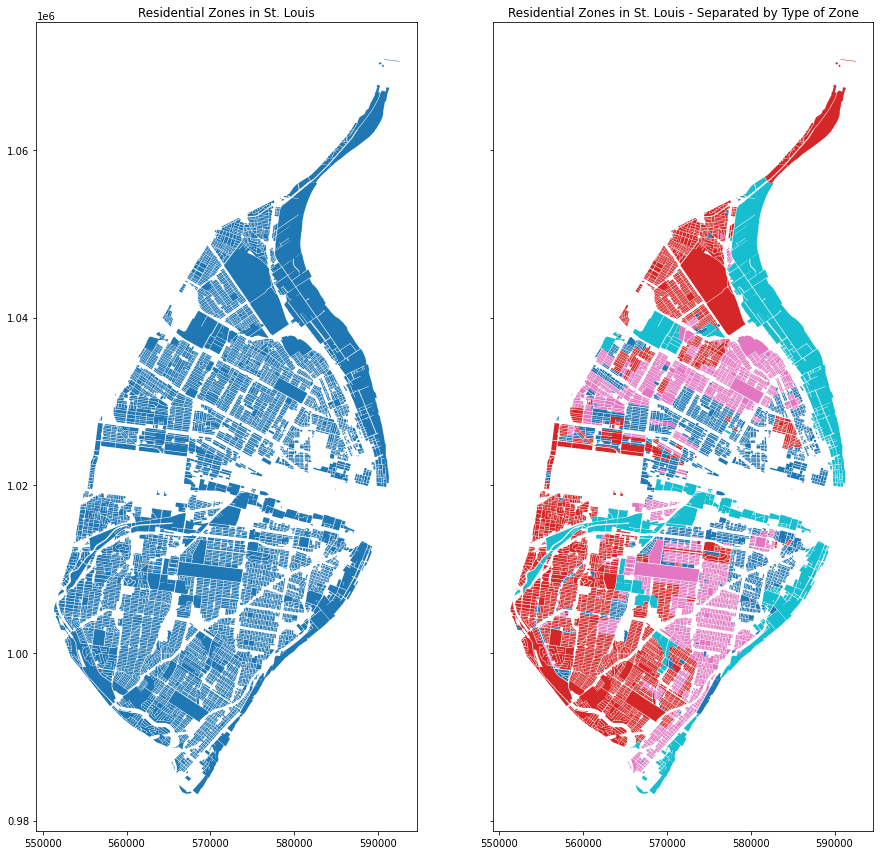

In [11]:
# visualize these two results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Zones in St. Louis')
ax2.set_title('Residential Zones in St. Louis - Separated by Type of Zone')
gdf_zoning_descr_flat.plot(ax=ax1)
gdf_zoning_descr_flat.plot(ax=ax2, column='description')


#### Compute the area (in sq. miles) of the dataset presented above.

In [12]:
# find area and convert to sq. miles
area_res_descr_flat = (gdf_zoning_descr_flat['geom'].area / (27878400.0)) 


In [13]:
# view the results by layer
area_res_descr_flat


layer
A    13.568645
B     7.273852
C     3.567473
D     1.269563
E     0.448253
K     8.208725
dtype: float64

In [14]:
# find the total for all layers combined
area_res_descr_flat_sum = area_res_descr_flat.sum()
area_res_descr_flat_sum


34.33651083270197

#### Pull nonrestricted area geometry from PostGIS database

In [15]:
# create sql statement and pull from db into a geopandas dataframe

# test to make sure the load actually worked
# query the table and read data into a geodf 
sql = "select * from stlnonrestrictedresidential;"
gdf_res_nonrestricted = gpd.read_postgis(sql, conn)
gdf_res_nonrestricted.head()


,layer,description,res,geom
0,K,Unrestricted,True,"POLYGON ((277730.586 310861.072, 277729.367 31..."
1,K,Unrestricted,True,"POLYGON ((277736.944 310959.863, 277736.928 31..."
2,K,Unrestricted,True,"POLYGON ((277703.617 310966.020, 277703.484 31..."
3,K,Unrestricted,True,"POLYGON ((277646.452 310973.432, 277651.714 31..."
4,K,Unrestricted,True,"POLYGON ((277676.495 310850.670, 277677.187 31..."


In [16]:
# Type 2) dissolve the zoning data into a multipolys split out by layer description 
# we only need the 'geometry' and our constant value column. Downselect to those to help clean up the output.
# gdf_zoning_descr_flat = gdf_zoning[['geom','layer']].dissolve(by='layer')
gdf_remain_descr_flat = gdf_res_nonrestricted.dissolve(by='layer')


In [17]:
gdf_remain_descr_flat

,geom,description,res
layer,,,
A,"MULTIPOLYGON (((269183.418 301926.984, 269181....",Single Family Residential,True
B,"MULTIPOLYGON (((271109.544 301794.844, 271107....",Two Family Residential,True
C,"MULTIPOLYGON (((274591.330 306995.146, 274580....",Multiple Family Residential,True
D,"MULTIPOLYGON (((274650.374 306974.262, 274652....",Multiple Family Residential,True
E,"MULTIPOLYGON (((270473.833 300840.537, 270449....",Multiple Family Residential,True
K,"MULTIPOLYGON (((271535.950 300859.790, 271523....",Unrestricted,True


In [18]:
gdf_remain_descr_flat.crs

<Projected CRS: EPSG:6512>
Name: NAD83(2011) / Missouri East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Missouri - counties of Bollinger; Butler; Cape Girardeau; Carter; Clark; Crawford; Dent; Dunklin; Franklin; Gasconade; Iron; Jefferson; Lewis; Lincoln; Madison; Marion; Mississippi; Montgomery; New Madrid; Oregon; Pemiscot; Perry; Pike; Ralls; Reynolds; Ripley; Scott; Shannon; St Charles; St Francois; St Louis; Ste. Genevieve; Stoddard; Warren; Washington; Wayne.
- bounds: (-91.97, 35.98, -89.1, 40.61)
Coordinate Operation:
- name: SPCS83 Missouri East zone (meters)
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

This data is in a CRS with units of METERS. We need to convert it so that it matches the other geodataframe.

In [19]:
# make sure our datasets are using the same CRS!
print('Starting all residential (gdf_zoning_descr_flat) CRS:', gdf_zoning_descr_flat.crs)
print('Starting non-restricted residential (gdf_remain_descr_flat) CRS:', gdf_remain_descr_flat.crs)
print('------------')

# convert to a common CRS
gdf_remain_descr_flat = gdf_remain_descr_flat.to_crs(gdf_zoning_descr_flat.crs)
print('New residential area (gdf_zoning) CRS:', gdf_remain_descr_flat.crs)


Starting all residential (gdf_zoning_descr_flat) CRS: epsg:26796
Starting non-restricted residential (gdf_remain_descr_flat) CRS: epsg:6512
------------
New residential area (gdf_zoning) CRS: epsg:26796


<AxesSubplot:title={'center':'Remaining Residential Zones in St. Louis - Separated by Type of Zone'}>

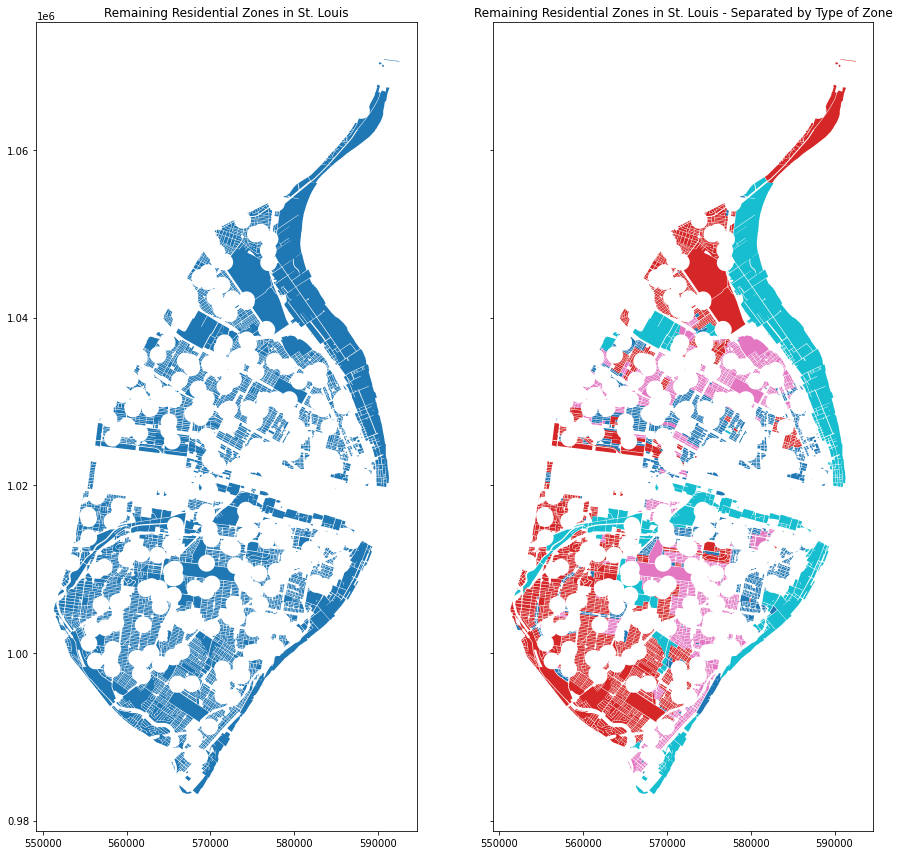

In [20]:
# visualize results side by side that are comparable to the plots from up above
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Remaining Residential Zones in St. Louis')
ax2.set_title('Remaining Residential Zones in St. Louis - Separated by Type of Zone')
gdf_remain_descr_flat.plot(ax=ax1)
gdf_remain_descr_flat.plot(ax=ax2, column='description')


#### Compute the area (in sq. miles) of the dataset presented above.

In [21]:
# find area and convert to sq. miles
area_remain_res_flat = (gdf_remain_descr_flat['geom'].area / (27878400.0)) 


In [22]:
# view the results by layer
area_remain_res_flat


layer
A    9.224099
B    3.405755
C    1.626515
D    0.631650
E    0.187943
K    7.556014
dtype: float64

In [23]:
# find the total for all layers combined
area_remain_res_flat_sum = area_remain_res_flat.sum()
area_remain_res_flat_sum


22.631976768082268

In [24]:
# compute some basic stats
area_diff = area_res_descr_flat_sum - area_remain_res_flat_sum
area_diff_percent = area_diff / area_res_descr_flat_sum * 100


## Results

<AxesSubplot:title={'center':'Residential Zones in St. Louis - After Restrictions Applied'}>

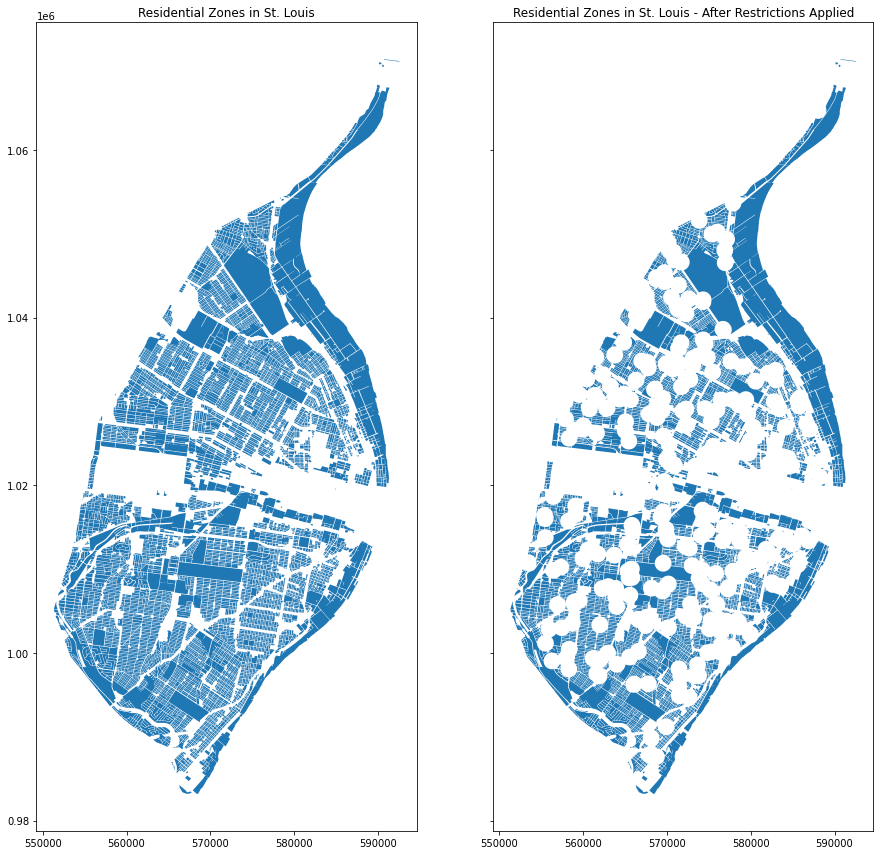

In [32]:
# same plots as above, but with before and after presentation
# visualize these two results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Zones in St. Louis')
ax2.set_title('Residential Zones in St. Louis - After Restrictions Applied')
gdf_zoning_descr_flat.plot(ax=ax1)
gdf_remain_descr_flat.plot(ax=ax2)


<AxesSubplot:title={'center':'Remaining Residential Zones in St. Louis - After Restrictions Applied'}>

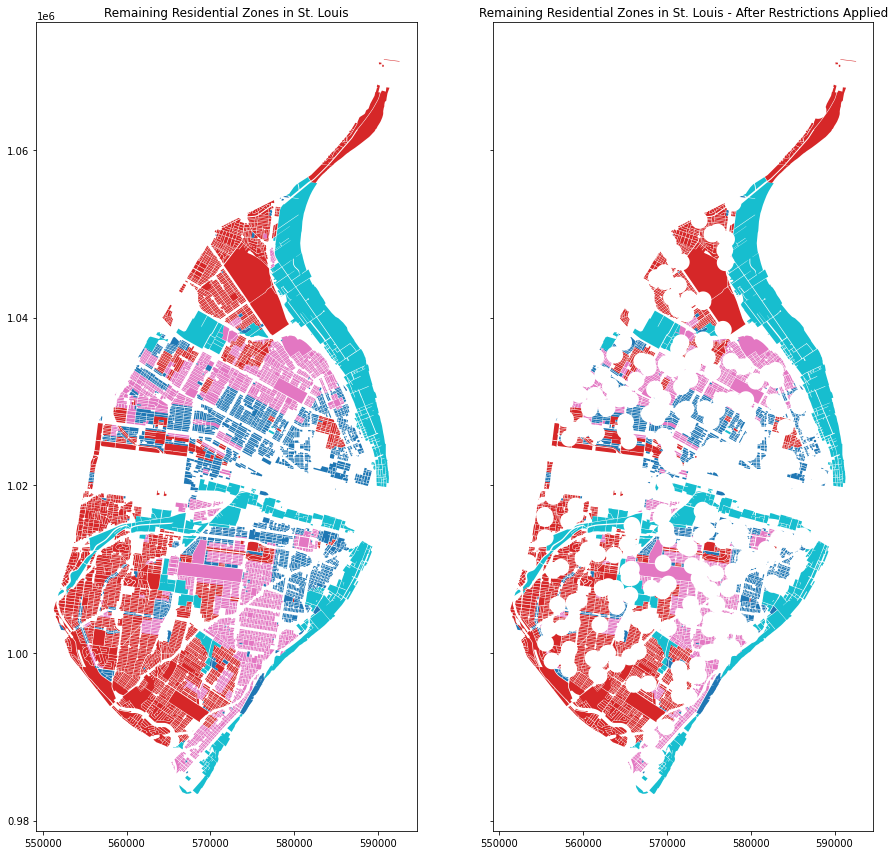

In [33]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Zones in St. Louis by Zone Type')
ax2.set_title('Residential Zones in St. Louis by Zone Type - After Restrictions Applied')
gdf_zoning_descr_flat.plot(ax=ax1, column='description')
gdf_remain_descr_flat.plot(ax=ax2, column='description')


In [25]:
# output some summary info
print("Livable area in St. Louis City for a registered sex offender is {0:.3f} square miles.".format(area_remain_res_flat_sum))
print("This is a reduction of {0:.3f} square miles (-{1:.2f}%) ".format(area_diff,area_diff_percent) + 
      "compared to the total livable residential area of {0:.3f} square miles.".format(area_res_descr_flat_sum))


Livable area in St. Louis City for a registered sex offender is 22.632 square miles.
This is a reduction of 11.705 square miles (-34.09%) compared to the total livable residential area of 34.337 square miles.


In [26]:
#close connection to the db
conn.close()

# work up a table of change per zone type

In [27]:
# # create sql statement and pull from db into a geopandas dataframe
# # we only need residential data here, so specify that during the SELECT
# sql = "SELECT layer, description, res, geometry as geom FROM stlzoning WHERE res = True;"
# gdf_zoning = gpd.read_postgis(sql, conn)
# # gpd_childcare = gpd_childcare.drop(columns='geometry') # drop the duplicate geometry column
# gdf_zoning.head()


In [28]:
# # Type 1) dissolve the zoning data into a single multipoly per layer
# # we only need the 'geometry' and our constant value column. Downselect to those to help clean up the output.
# gdf_zoning_flat = gdf_zoning[['geom','res']].dissolve(by='res')


In [29]:
# gdf_zoning_flat